In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

import pickle

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import roc_curve, roc_auc_score, auc, mean_squared_error, confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, VotingClassifier

def return_plot(estimator):
    df['Returns'] = df.Close.pct_change()
    df['Predicted_Signal'] = estimator.predict(X)
    Cumulative_returns = np.cumsum(df[split:]['Returns'])
    df['Startegy_returns'] = df['Returns']* df['Predicted_Signal'].shift(1)
    Cumulative_Strategy_returns = np.cumsum(df[split:]['Startegy_returns'])
    print('Return: {}%'.format(round(Cumulative_Strategy_returns[-1] * 100), 2))
    plt.figure(figsize=(10,5))
    plt.plot(Cumulative_returns, color='r',label = 'Returns')
    plt.plot(Cumulative_Strategy_returns, color='g', label = 'Strategy Returns')
    plt.legend()
    plt.show()

def roc_plot(estimator, auc_cv=False, title="ROC Curve"):
    X_ = X_test
    y_ = y_test
    y_pred = estimator.predict(X_)
    y_pred_prob = estimator.predict_proba(X_)[:,1]
    #y_pred_prob = y_pred
    fpr, tpr, thresholds = roc_curve(y_, y_pred_prob)
    print('Train Score: {}%'.format(round(estimator.score(X_train, y_train)*100, 2)))
    print("Test Score: {}%".format(round(estimator.score(X_, y_)*100, 2)))
    print(confusion_matrix(y_, y_pred))
    print(classification_report(y_, y_pred))

    # Plot ROC curve
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.show()

    #If the AUC is greater than 0.5, the model is better than random guessing. Always a good sign!
    print("AUC: {}%".format(round(roc_auc_score(y_, y_pred_prob)*100, 2)))
    
    if (auc_cv):
        cv_auc = cross_val_score(estimator, X, y, cv=5, scoring='roc_auc', n_jobs=-1)
        print("AUC scores computed using 5-fold cross-validation: {}%".format(round(np.mean(cv_auc)*100, 2)))
  

df = pd.read_csv('data1.csv', index_col='Datetime')
y = df.Target.values
X = df.drop(['Target', 'Close'], axis=1).values

split = int(len(df) * 0.60)
X_train = X[:split]
X_test = X[split:]
y_train = y[:split]
y_test = y[split:]

print('X shape {}'.format(X_train.shape))

X shape (2904, 7)


In [61]:
df.tail()

,Close,Target,daily_vol,Returns,Candle_body,Linear_regression_diff,Linear_angle_diff,Linear_slope_diff,Linear_intercept_diff
Datetime,,,,,,,,,
2019-02-01,1.14547,-1,0.004482,0.000568,-0.00065,0.001506,0.009793,0.000171,-0.000716
2019-02-03,1.14543,-1,0.004438,-0.000035,-0.00040,0.001232,0.006937,0.000121,-0.000342
2019-02-04,1.14349,-1,0.004402,-0.001694,0.00194,0.000118,-0.003588,-0.000063,0.000932
2019-02-05,1.14087,-1,0.004396,-0.002291,0.00261,-0.000714,-0.009048,-0.000158,0.001339
2019-02-06,1.13656,-1,0.004435,-0.003778,0.00431,-0.001893,-0.016486,-0.000288,0.001847


# Final Model

LogisticRegression 0.5211776859504132
AdaBoostClassifier 0.5191115702479339
Pipeline 0.5222107438016529
Train Score: 51.34%
Test Score: 51.96%
[[268 710]
 [220 738]]
              precision    recall  f1-score   support

          -1       0.55      0.27      0.37       978
           1       0.51      0.77      0.61       958

   micro avg       0.52      0.52      0.52      1936
   macro avg       0.53      0.52      0.49      1936
weighted avg       0.53      0.52      0.49      1936



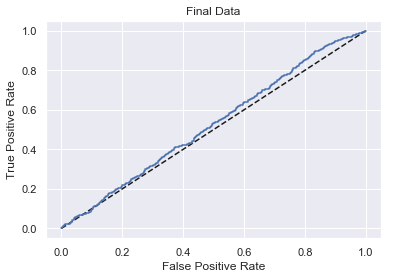

AUC: 52.52%
AUC scores computed using 5-fold cross-validation: 51.91%
Return: 37.0%


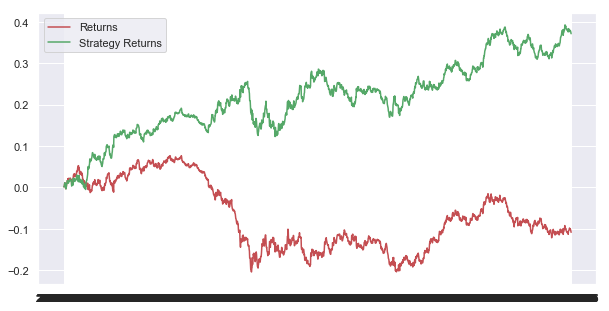

In [62]:
# Final Model
params = {'C': 0.03359818286283781, 'class_weight': None, 'multi_class': 'multinomial', 'n_jobs': -1, 'penalty': 'l2', 'solver': 'newton-cg', 'tol': 1e-05, 'verbose': 0}
log_reg = LogisticRegression(**params)
ada_log = AdaBoostClassifier(
    base_estimator=log_reg,
    n_estimators=1000,
    algorithm="SAMME",
    learning_rate=0.5
)
pipe_log = Pipeline([
    ('polynomial', PolynomialFeatures()),
    ('log_reg', log_reg)
])
clf1 = log_reg #best params
clf2 = ada_log #best params + ada boosting
clf3 = pipe_log #best params + polynomials

voting_clf = VotingClassifier(
    estimators=[
        ('clf1', clf1),
        ('clf2', clf2),
        ('clf3', clf3)
    ],
    voting='soft'
)
voting_clf.fit(X_train, y_train)

for clf in (clf1, clf2, clf3):
    clf.fit(X_train, y_train)
    #roc_plot(clf, auc_cv=True, final=True)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))
    
roc_plot(voting_clf, auc_cv=True, title="Final Data")
return_plot(voting_clf)

with open('log_reg_data1_final.pickle', 'wb') as file:
    pickle.dump(voting_clf, file)

# Find Best Model

In [3]:
params_l1 = {
    'log_reg__penalty': ['l1'],
    'log_reg__C': np.logspace(-4, 4, 20),
    'log_reg__tol': [0.00001, 0.0001, 0.001, 0.01, 0.10],
    'log_reg__class_weight': [None, 'balanced'],
    'log_reg__solver': ['saga'],
    'log_reg__multi_class': ['ovr', 'multinomial', 'auto'],
    'log_reg__verbose': [1],
    'log_reg__n_jobs': [-1]
}
params_l2 = {
    'penalty': ['l2'],
    'C': np.logspace(-4, 4, 20),
    'tol': [0.00001, 0.0001, 0.001, 0.01, 0.10],
    'class_weight': [None, 'balanced'],
    'solver': ['newton-cg', 'lbfgs', 'sag'],
    'multi_class': ['ovr', 'multinomial', 'auto'],
    'verbose': [1],
    'n_jobs': [-1]
}

In [29]:
# polynomial with ada
ada_clf = AdaBoostClassifier(
    base_estimator=log_reg,
    n_estimators=1000,
    algorithm="SAMME",
    learning_rate=0.5
)
ada_clf.fit(X_train, y_train)
roc_plot(ada_clf)
return_plot(ada_clf)

ValueError: Pipeline doesn't support sample_weight.

Train Score: 0.5237603305785123
Accuracy Score: 0.5320247933884298
[[112 377]
 [ 76 403]]
              precision    recall  f1-score   support

          -1       0.60      0.23      0.33       489
           1       0.52      0.84      0.64       479

   micro avg       0.53      0.53      0.53       968
   macro avg       0.56      0.54      0.49       968
weighted avg       0.56      0.53      0.48       968



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished


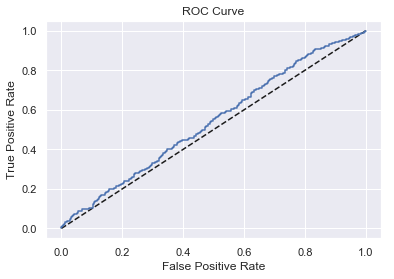

AUC: 0.5397492219219489
Return: 38.0%


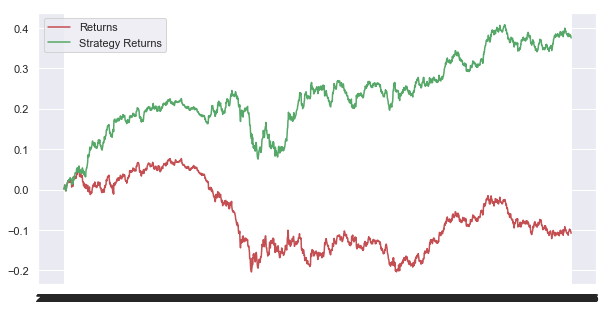

In [28]:
# polynomials
steps = [
    ('polynomial', PolynomialFeatures()),
    ('log_reg', log_reg)
]
pipeline = Pipeline(steps).fit(X_train, y_train)
roc_plot(pipeline)
return_plot(pipeline)

In [23]:
params = {'C': 0.03359818286283781, 'class_weight': None, 'multi_class': 'multinomial', 'n_jobs': -1, 'penalty': 'l2', 'solver': 'newton-cg', 'tol': 1e-05, 'verbose': 1}
log_reg = LogisticRegression(**params)

Train Score: 0.5141184573002755
Accuracy Score: 0.53099173553719
[[151 338]
 [116 363]]
              precision    recall  f1-score   support

          -1       0.57      0.31      0.40       489
           1       0.52      0.76      0.62       479

   micro avg       0.53      0.53      0.53       968
   macro avg       0.54      0.53      0.51       968
weighted avg       0.54      0.53      0.51       968



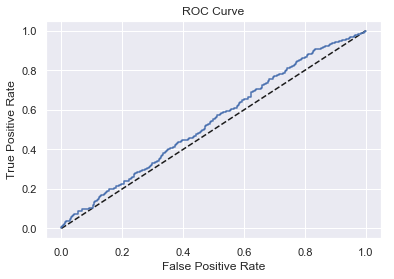

AUC: 0.5397919148191316
Return: 37.0%


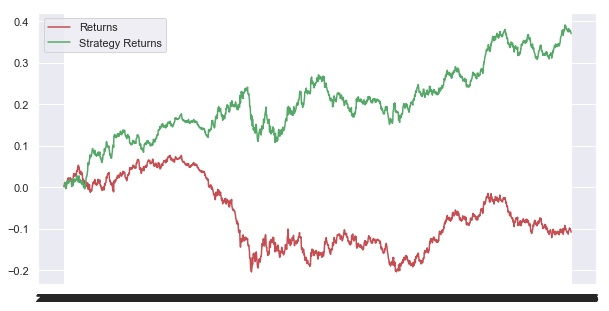

In [12]:
ada_clf = AdaBoostClassifier(
    base_estimator=log_reg,
    n_estimators=1000,
    algorithm="SAMME",
    learning_rate=0.5
)
ada_clf.fit(X_train, y_train)
roc_plot(ada_clf)
return_plot(ada_clf)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Train Score: 0.5237603305785123
Accuracy Score: 0.5299586776859504
[[112 377]
 [ 78 401]]
              precision    recall  f1-score   support

          -1       0.59      0.23      0.33       489
           1       0.52      0.84      0.64       479

   micro avg       0.53      0.53      0.53       968
   macro avg       0.55      0.53      0.48       968
weighted avg       0.55      0.53      0.48       968



[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.9s finished


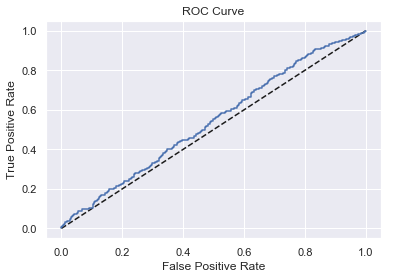

AUC: 0.5397449526322307
Return: 0.3663236383639984%


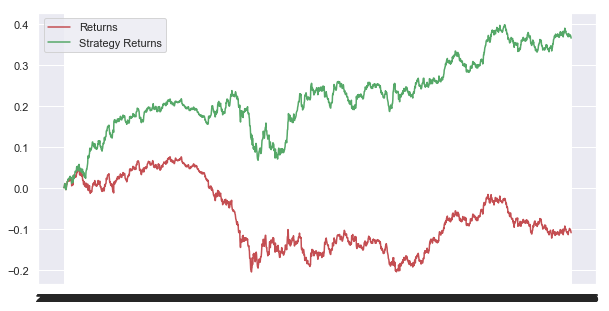

In [21]:
log_reg.fit(X_train, y_train)
roc_plot(log_reg)
return_plot(log_reg)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:   14.1s remaining:   42.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   15.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    0.9s


Train Score: 0.5006887052341598
Accuracy Score: 0.49483471074380164
[[  0 489]
 [  0 479]]
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       489
           1       0.49      1.00      0.66       479

   micro avg       0.49      0.49      0.49       968
   macro avg       0.25      0.50      0.33       968
weighted avg       0.24      0.49      0.33       968



[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.5s finished
/anaconda2/envs/python3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda2/envs/python3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda2/envs/python3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


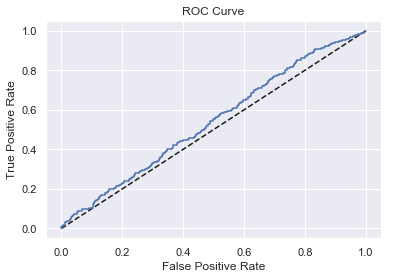

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


AUC: 0.5397961841088498


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.4s remaining:    1.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.7s finished


Return: -11.0%


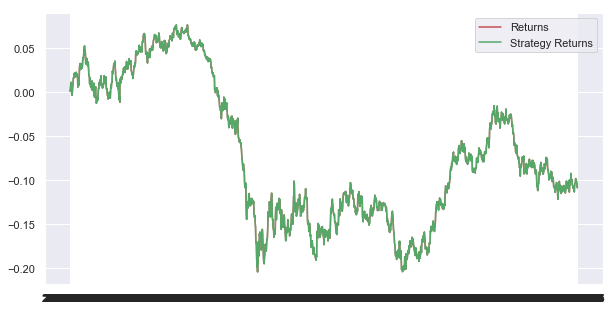

In [30]:
log_bag = BaggingClassifier(
    base_estimator=pipeline,
    n_estimators=1000,
    max_samples=500,
    max_features=X.shape[1],
    bootstrap=True,
    n_jobs=-1,
    verbose=1
)
log_bag.fit(X_train, y_train)
roc_plot(log_bag)
return_plot(log_bag)

In [7]:
# grid without pipeline
log_cv = GridSearchCV(LogisticRegression(), params_l2, cv=5, n_jobs=-1)
log_cv.fit(X_train, y_train)
lr = log_cv.best_estimator_
#log_cv.fit(X_train, y_train)
#print('Best Params: {}'.format(log_cv.best_params_))
#print('Best Score: {}'.format(log_cv.best_score_))
#roc_plot(log_cv, auc_cv=False, title="Tune without pipeline")
#return_plot(log_cv)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished


Train Score: 52.38%
Test Score: 52.12%
[[205 773]
 [154 804]]
              precision    recall  f1-score   support

          -1       0.57      0.21      0.31       978
           1       0.51      0.84      0.63       958

   micro avg       0.52      0.52      0.52      1936
   macro avg       0.54      0.52      0.47      1936
weighted avg       0.54      0.52      0.47      1936



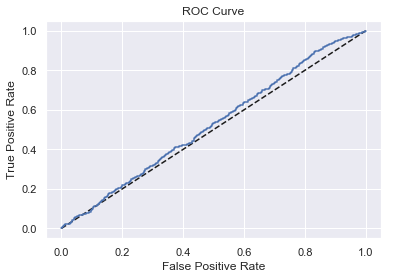

AUC: 52.52%
Return: 37.0%


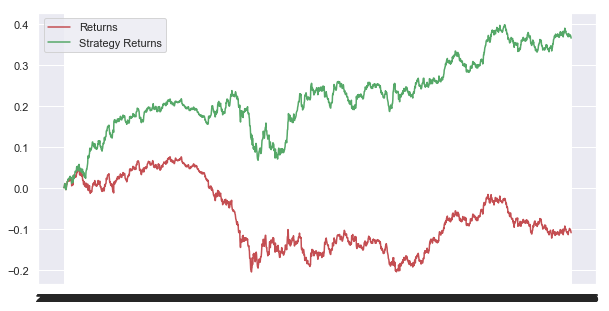

In [13]:
roc_plot(lr)
return_plot(lr)

Train Score: 0.5161845730027548
Accuracy Score: 0.5247933884297521
[[230 259]
 [201 278]]
              precision    recall  f1-score   support

          -1       0.53      0.47      0.50       489
           1       0.52      0.58      0.55       479

   micro avg       0.52      0.52      0.52       968
   macro avg       0.53      0.53      0.52       968
weighted avg       0.53      0.52      0.52       968



/anaconda2/envs/python3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


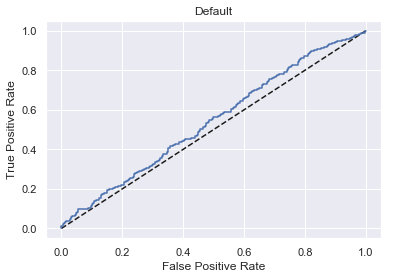

AUC: 0.5405988105758845
AUC scores computed using 5-fold cross-validation: 0.5187834455541336
Return: -0.06203487132250818%


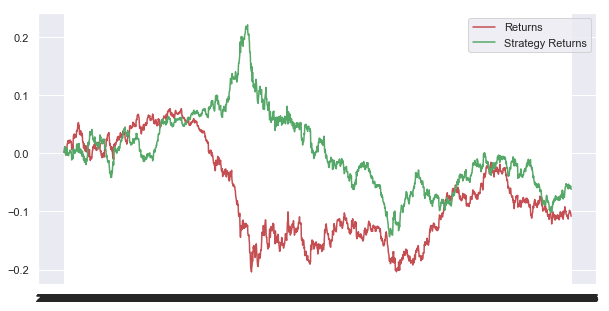

In [28]:
log_reg = LogisticRegression().fit(X_train, y_train)
roc_plot(log_reg, auc_cv=True, title='Default')
return_plot(log_reg)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished


rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
convergence after 5 epochs took 0 seconds
Best Params: {'C': 0.03359818286283781, 'class_weight': None, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'sag', 'tol': 0.0001, 'verbose': 1}
Best Score: 0.5213498622589532
Train Score: 0.5161845730027548
Accuracy Score: 0.5216942148760331
[[251 238]
 [225 254]]
              precision    recall  f1-score   support

          -1       0.53      0.51      0.52       489
           1       0.52      0.53      0.52       479

   micro avg       0.52      0.52      0.52       968
   macro avg       0.52      0.52      0.52       968
weighted avg       0.52      0.52      0.52       968



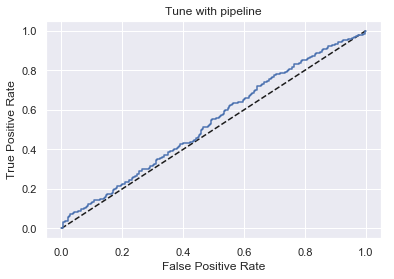

AUC: 0.5357488974559302
Return: -0.10856048444702349%


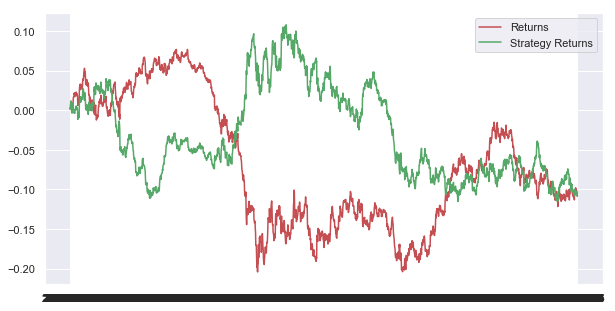

In [9]:
# grid with pipeline
steps = [
    ('scaler', StandardScaler()),
    ('log_reg', LogisticRegression())
]
pipeline = Pipeline(steps)
log_cv_pipe = GridSearchCV(pipeline, params_l2, cv=5, n_jobs=-1)
log_cv_pipe.fit(X_train, y_train)
print('Best Params: {}'.format(log_cv.best_params_))
print('Best Score: {}'.format(log_cv.best_score_))
roc_plot(log_cv_pipe, auc_cv=False, title="Tune with pipeline")
return_plot(log_cv_pipe)


Train Score: 0.5175619834710744
Accuracy Score: 0.5289256198347108
[[173 316]
 [140 339]]
              precision    recall  f1-score   support

          -1       0.55      0.35      0.43       489
           1       0.52      0.71      0.60       479

   micro avg       0.53      0.53      0.53       968
   macro avg       0.54      0.53      0.51       968
weighted avg       0.54      0.53      0.51       968



/anaconda2/envs/python3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


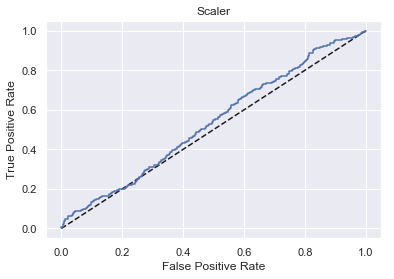

AUC: 0.5339088335873561
AUC scores computed using 5-fold cross-validation: 0.5141835484575802
Return: -0.01707333502002084%


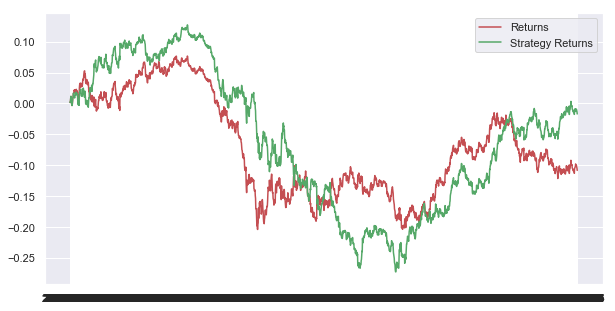

In [31]:
steps = [
    ('scaler', StandardScaler()),
    ('log_reg', LogisticRegression())
]
pipeline = Pipeline(steps)
pipeline.fit(X_train, y_train)
roc_plot(pipeline, auc_cv=True, title="Scaler")
return_plot(pipeline)